## Game Duration Across Regions

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Introduction

DOTA2 is a multiplayer online battle arena video game. Released by Valve in 2013, it currently enjoys over 600,000 players mostly participating in public matchmaking games. Due to input latency, players connect to server clusters spread across different regions globally. So players from the east coast of North America will play with other players from the east coast but not from Eastern Europe, South America, Southeast Asia or other regions.

Because of this segmentation, communities around the game often discuss overall styles of play for different regions. The belief being that strategies tend to spread within the public matchmaking system more quickly than those can be shared outside and that large, insular groups of players will come to different conclusions as to what the best strategies are.

For this analysis I will focus on the average game length. I believe different approaches in strategy may result in shorter or longer overall game times if one region plays in a generally more passive or aggressive style.

## Data Load and Cleanup

The data includes matches.csv and cluster_regsions.csv from [this](https://www.kaggle.com/devinanzelmo/dota-2-matches) kaggle data set.

In [ ]:
matches = pd.read_csv('match.csv')

matches.info()
matches.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   match_id                 50000 non-null  int64
 1   start_time               50000 non-null  int64
 2   duration                 50000 non-null  int64
 3   tower_status_radiant     50000 non-null  int64
 4   tower_status_dire        50000 non-null  int64
 5   barracks_status_dire     50000 non-null  int64
 6   barracks_status_radiant  50000 non-null  int64
 7   first_blood_time         50000 non-null  int64
 8   game_mode                50000 non-null  int64
 9   radiant_win              50000 non-null  bool 
 10  negative_votes           50000 non-null  int64
 11  positive_votes           50000 non-null  int64
 12  cluster                  50000 non-null  int64
dtypes: bool(1), int64(12)
memory usage: 4.6 MB


,match_id,start_time,duration,tower_status_radiant,tower_status_dire,barracks_status_dire,barracks_status_radiant,first_blood_time,game_mode,radiant_win,negative_votes,positive_votes,cluster
0,0,1446750112,2375,1982,4,3,63,1,22,True,0,1,155
1,1,1446753078,2582,0,1846,63,0,221,22,False,0,2,154
2,2,1446764586,2716,256,1972,63,48,190,22,False,0,0,132
3,3,1446765723,3085,4,1924,51,3,40,22,False,0,0,191
4,4,1446796385,1887,2047,0,0,63,58,22,True,0,0,156


The data are in pretty good shape for us already. We will increase readability by converting the 'duration' column to minutes from seconds and the 'date' column to a much more understandable datetime.

Finally, we'll merge our matches table with the clusters table. This way the games can be grouped by the server cluster rather than specific server. When player's queue for a game of DOTA, they choose clusters to play on rather than more specific servers. This merge ensures our data is split into relevant groups.

In [ ]:
# Convert duration from seconds to minutes for readability
matches['duration'] = matches['duration'] / 60

# Convert Unix timestamp to datetime
matches['date'] = pd.to_datetime(matches['start_time'], unit = 's')

# Merge the clusters table into the matches
clusters = pd.read_csv('cluster_regions.csv')
matches =  matches.merge(clusters, on = 'cluster', how = 'left')

# Drop columns not used in this notebook's analysis 
matches.drop(columns = ['start_time', 'tower_status_radiant', 'tower_status_dire', 
              'barracks_status_radiant', 'barracks_status_dire', 'first_blood_time', 
              'radiant_win', 'negative_votes', 'positive_votes', 'cluster',
              'match_id'], inplace = True)

matches.info()
matches.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   duration   50000 non-null  float64       
 1   game_mode  50000 non-null  int64         
 2   date       50000 non-null  datetime64[ns]
 3   region     50000 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.9+ MB


,duration,game_mode,date,region
0,39.583333,22,2015-11-05 19:01:52,SINGAPORE
1,43.033333,22,2015-11-05 19:51:18,SINGAPORE
2,45.266667,22,2015-11-05 23:03:06,EUROPE
3,51.416667,22,2015-11-05 23:22:03,AUSTRIA
4,31.450000,22,2015-11-06 07:53:05,SINGAPORE


## Dataset Analysis

EUROPE                  18447
US EAST                 10904
SINGAPORE                7938
US WEST                  3774
AUSTRALIA                2514
AUSTRIA                  2278
BRAZIL                   1828
STOCKHOLM                1713
PW TELECOM SHANGHAI       281
PW TELECOM ZHEJIANG        91
PW TELECOM GUANGDONG       90
JAPAN                      88
PW UNICOM                  34
DUBAI                      18
CHILE                       2
Name: region, dtype: int64


Text(0.5, 1.0, 'Frequencies of regions within our dataset')

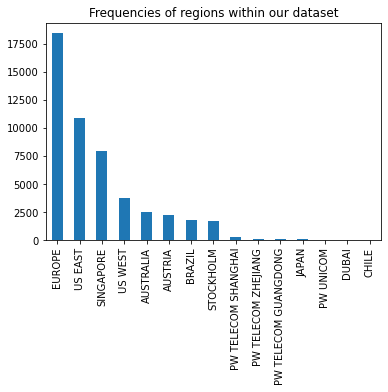

In [ ]:
print(matches['region'].value_counts())
matches['region'].value_counts().plot(kind = 'bar').set_title('Frequencies of regions within our dataset')

The data set mostly contains games from US East, US West, Europe, and Southeast Asia (Singapore). We will focus our comparisons mostly there.

In [ ]:
# Drop any region outside of the ones we are interested in
regions_to_keep = ['EUROPE', 'US EAST', 'SINGAPORE', 'US WEST']

matches.drop(matches[ ~matches['region'].isin(regions_to_keep)].index, inplace = True)
matches['region'].value_counts()

EUROPE       18447
US EAST      10904
SINGAPORE     7938
US WEST       3774
Name: region, dtype: int64

<AxesSubplot:xlabel='region', ylabel='duration'>

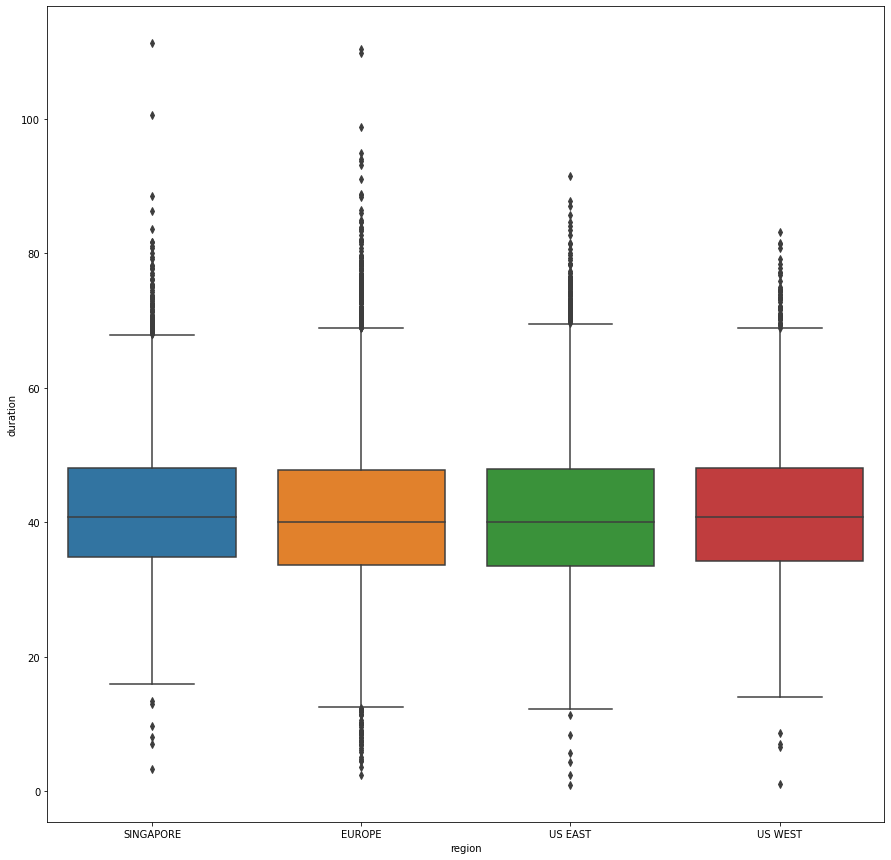

In [ ]:
#matches.boxplot('duration', by = 'region')
plt.figure(figsize=(15,15))
sns.boxplot(x = 'region', y = 'duration', data=matches)

Initially, each region looks relatively symmetrical with no extreme outliers. The quartiles all look strikingly similar to one another. There are no apparent differeneces so far.

## Test our Hypothesis

We're going to test for differences in the population means between the four regions of play we've chosen. Our plan is to use an ANOVA test, so we must first check our samples for normality.

Match Duration Globally
DescribeResult(nobs=41063, minmax=(0.9833333333333333, 111.21666666666667), mean=41.31704575895575, variance=110.6136580371394, skewness=0.515428883613318, kurtosis=0.6537740279459756)

SINGAPORE
DescribeResult(nobs=7938, minmax=(3.3666666666666667, 111.21666666666667), mean=41.81513185521122, variance=97.18625641101345, skewness=0.566909016997143, kurtosis=0.8733170793693614)

EUROPE
DescribeResult(nobs=18447, minmax=(2.466666666666667, 110.36666666666666), mean=41.08315534594605, variance=115.79555903261455, skewness=0.5167453458389033, kurtosis=0.7659971283943983)

US EAST
DescribeResult(nobs=10904, minmax=(0.9833333333333333, 91.56666666666666), mean=41.19199529224749, variance=112.2984209687632, skewness=0.5065681128794413, kurtosis=0.3494259852452819)

US WEST
DescribeResult(nobs=3774, minmax=(1.05, 83.25), mean=41.77394011658717, variance=107.70191479206635, skewness=0.5001475818938786, kurtosis=0.49427538784507163)



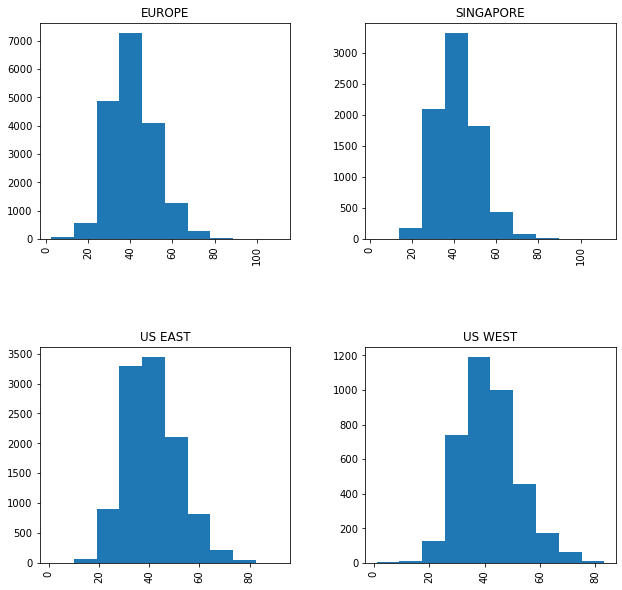

In [ ]:
print('Match Duration Globally')
print(stats.describe(matches['duration']))
print()

for region in matches['region'].unique():
    region_games = matches[matches['region'] == region]
    print(region)
    print(stats.describe(region_games['duration']))
    print()
    
matches['duration'].hist(by = matches['region'], figsize = (10,10))
plt.show()

All of the regions have a slight right skew, but measurements of skewdness and kurtosis are within acceptable parameters. The groups variations are roughly the same as well. We meet the conditions to perform a one-way ANOVA.


# One-way ANOVA 

Null Hypothesis: The regions all have equal aveage game lengths.

Alternative Hypothesis: There is at least one pair of regions that have unequal average game lengths.

In [ ]:
# Perform one-way ANOVA on our chosen regions

durations_by_region = []
for region in regions_to_keep:
    durations_by_region.append(matches[matches['region'] == region]['duration'])
    
F, p = stats.f_oneway(*durations_by_region)

print('Test Statistic F = {}'.format(F))
print('P-value = {}'.format(p))

Test Statistic F = 11.872995171390206
P-value = 9.080397967394979e-08


With a pvalue less than 0.05, we can reject the null hypothesis. There likely is a pair of regions with differeing average game length.

To further probe this, we will perform Tukey's HSD to investigate  the differences between each pair of regions. 

# Tukey's HSD

In [ ]:
tukey = pairwise_tukeyhsd(endog = matches['duration'],
                         groups = matches['region'],
                         alpha = 0.05)

tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
EUROPE,SINGAPORE,0.732,0.001,0.3694,1.0945,True
EUROPE,US EAST,0.1088,0.8041,-0.2174,0.4351,False
EUROPE,US WEST,0.6908,0.0013,0.2082,1.1733,True
SINGAPORE,US EAST,-0.6231,0.001,-1.0216,-0.2246,True
SINGAPORE,US WEST,-0.0412,0.9,-0.5752,0.4929,False
US EAST,US WEST,0.5819,0.0178,0.0718,1.092,True


Intriguing results.

There appears to be two pairs of closely related regions. Europe and US Eash have no statistically signifance difference in average game time but both do differ with the other two regions. Singapore and US West are likewise similar to each other but not the others.

# Conclusion

While we can conclude that regions have different, the results are not likely to be significant. Looking at the details in Tukey's test, we can see that the differences between populations is likely no more than a minute of duration. With a global average time of 41 minutes in our sample, a minute's difference changes average game time between 2% and 3%. It's not clear with current analysis that this is an indication of major strategy differences.

A greater indication of differences in strategies may come from what heros are chosen by players across regions. At the beginning of each match, every player chooses from a pool of over 130 characters to play for the game. Each has differeing strengths/weaknesses and encourages certain styles of play.

Teamfight analysis might also prove better ground for finding difference. A look at how early or ofen fights break out could be a good indicator as to the level agression within a region.